In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import yaml
import hydra
from IPython.display import Markdown, display
from omegaconf import OmegaConf
import torch
from src.utils import get_cfg_from_from_ckpt_path
from src.ecs_classification import ECS_classification
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

# Load data

In [2]:
ss_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ecs_path = "/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc"

In [3]:
ssf_da = xr.open_dataarray(ss_path).transpose("time", "lat", "lon", "z")
ecs_da = xr.open_dataarray(ecs_path).transpose("time", "lat", "lon")

In [4]:
with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/profiles_of_interest_idx.pkl", "rb") as file:
    profile_idx_dict = pickle.load(file)

profile_idx_dict

{'min_std': tensor([[ 18, 100,  83],
         [ 18, 100,  82],
         [ 18, 100,  84],
         [ 18, 101,  83],
         [ 35, 100,  85],
         [ 18,  99,  83],
         [ 35,  99,  85],
         [ 35, 100,  86],
         [ 18, 101,  84],
         [ 35,  99,  84],
         [ 18,  99,  82],
         [ 35,  99,  86],
         [ 18, 101,  82],
         [ 35, 100,  84],
         [ 18,  99,  84],
         [ 18, 100,  81],
         [ 35, 100,  87],
         [ 35,  99,  83],
         [ 18, 100,  85],
         [ 18,  99,  81],
         [ 18, 101,  85],
         [ 18, 101,  81],
         [ 35, 100,  83],
         [ 35,  99,  87],
         [ 18,  98,  83],
         [ 18, 102,  83],
         [ 35, 101,  85],
         [ 35,  98,  84],
         [ 18, 102,  84],
         [ 35, 101,  86]]),
 'max_std': tensor([[ 22, 107,   0],
         [ 22, 107,   1],
         [ 22, 108,   1],
         [ 22, 106,   0],
         [ 22, 110,   4],
         [ 22, 108,   2],
         [ 22, 109,   3],
         [ 22,

In [5]:
coords = ssf_da.coords

In [6]:
z = coords['z'].data
z

array([4.80454775e-01, 1.55879158e+00, 2.79421042e+00, 4.18731055e+00,
       5.73867311e+00, 7.44886087e+00, 9.31841791e+00, 1.13478694e+01,
       1.35377212e+01, 1.58884598e+01, 1.84005520e+01, 2.10744444e+01,
       2.39105636e+01, 2.69093157e+01, 3.00710862e+01, 3.33962398e+01,
       3.68851201e+01, 4.05380494e+01, 4.43553288e+01, 4.83372378e+01,
       5.24840340e+01, 5.67959536e+01, 6.12732103e+01, 6.59159962e+01,
       7.07244809e+01, 7.56988119e+01, 8.08391144e+01, 8.61454909e+01,
       9.16180218e+01, 9.72567647e+01, 1.03061755e+02, 1.09033005e+02,
       1.15170504e+02, 1.21474221e+02, 1.27944100e+02, 1.34580064e+02,
       1.41382012e+02, 1.48349821e+02, 1.55483348e+02, 1.62782425e+02,
       1.70246863e+02, 1.77876449e+02, 1.85670952e+02, 1.93630115e+02,
       2.01753662e+02, 2.10041294e+02, 2.18492691e+02, 2.27107512e+02,
       2.35885396e+02, 2.44825959e+02, 2.53928797e+02, 2.63193486e+02,
       2.72619583e+02, 2.82206622e+02, 2.91954120e+02, 3.01861573e+02,
      

In [7]:
y_min_axs = -20
y_max_axs = 1020
x_min_axs = 1450
x_max_axs = 1550

In [8]:
plt.style.use('ggplot')

img_format = "png"

# Functions

In [3]:
def get_ecs(z: np.array, c: np.array):
    
    sign_change_indices = np.where(np.diff(np.sign(np.diff(c))))[0]
    if len(sign_change_indices) > 0:
        first_sign_change_index = sign_change_indices[0] + 1 
        
        z_ecs, c_ecs = z[first_sign_change_index], c[first_sign_change_index]
        return max(z[0], np.sign(c_ecs - c[0]) * z_ecs)


In [13]:
c= np.array([0.7113, 0.7112, 0.7112, 0.7113, 0.7115, 0.7118, 0.7121, 0.7124, 0.7128,
        0.7132, 0.7137, 0.7142, 0.7147, 0.7153, 0.7159, 0.7166, 0.7172, 0.7179,
        0.7187, 0.7194, 0.7202, 0.7211, 0.7220, 0.7229, 0.7238, 0.7248, 0.7258,
        0.7268, 0.7279, 0.7290, 0.7301, 0.7313, 0.7325, 0.7337, 0.7350, 0.7363,
        0.7376, 0.7389, 0.7403, 0.7417, 0.7431, 0.7445, 0.7458, 0.7471, 0.7482,
        0.7492, 0.7502, 0.7512, 0.7523, 0.7533, 0.7542, 0.7552, 0.7562, 0.7572,
        0.7580, 0.7586, 0.7587, 0.7583, 0.7573, 0.7558, 0.7543, 0.7529, 0.7518,
        0.7507, 0.7497, 0.7487, 0.7475, 0.7462, 0.7446, 0.7428, 0.7406, 0.7380,
        0.7350, 0.7315, 0.7276, 0.7232, 0.7183, 0.7127, 0.7066, 0.7000, 0.6929,
        0.6855, 0.6776, 0.6690, 0.6597, 0.6498, 0.6392, 0.6282, 0.6167, 0.6047,
        0.5922, 0.5793, 0.5661, 0.5529, 0.5399, 0.5271, 0.5143, 0.5016, 0.4890,
        0.4764, 0.4641, 0.4523, 0.4411, 0.4303, 0.4203, 0.4111, 0.4027])

In [14]:
get_ecs(z,c)

0.4804547754091311

In [19]:
c = np.array([0.7010, 0.7012, 0.7015, 0.7017, 0.7020, 0.7024, 0.7027, 0.7031, 0.7036,
        0.7040, 0.7045, 0.7050, 0.7056, 0.7062, 0.7068, 0.7074, 0.7081, 0.7088,
        0.7096, 0.7103, 0.7111, 0.7119, 0.7128, 0.7136, 0.7145, 0.7155, 0.7164,
        0.7174, 0.7184, 0.7194, 0.7205, 0.7215, 0.7227, 0.7238, 0.7250, 0.7262,
        0.7274, 0.7287, 0.7300, 0.7314, 0.7327, 0.7341, 0.7356, 0.7370, 0.7385,
        0.7400, 0.7415, 0.7430, 0.7444,   0.7444,    np.nan,    np.nan,    np.nan,    np.nan,
        np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,
        np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,
        np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,
        np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,
        np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,
        np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan,    np.nan])

In [20]:
get_ecs(z,c)

235.88539598193603

In [17]:
def get_ecs_binary_classification_along_profiles(z: np.array,
                                  c: np.array):
    
    classif = np.zeros(len(c))
    sign_change_indices = np.where(np.diff(np.sign(np.diff(c))))[0]
    
    if len(sign_change_indices) > 0:
        first_sign_change_index = sign_change_indices[0] + 1 
        
        if c[first_sign_change_index] > c[0]:
            classif[first_sign_change_index] = 1
        
    
    return classif



In [27]:
def get_ecs_existence(z: np.array,
                      c: np.array):
    

    sign_change_indices = np.where(np.diff(np.sign(np.diff(c))))[0]
    
    if (len(sign_change_indices) > 0) and (c[sign_change_indices][0] > c[0]):       
        return 1
    
    else:    
        return 0

In [9]:
def plot_4_profiles(ssf_da: xr.DataArray,
                    ecs_da: xr.DataArray, 
                    profile_idx_dict: dict,
                    profiles: str,
                    y_lim: tuple = (-20,1020),
                    savefig: bool = False):

    style = ['-', '--', '-.', ':']
    colors = ['lightcoral','mediumseagreen','deepskyblue','orchid']
    #colors_pca = ['brown', ,'gold','chocolate']
    title_dict = {'min_std': "Celerity profiles presenting the lowest std",
              'max_std': "Celerity profiles presenting the highest std",
              'min_std_150': "Celerity profiles presenting the lowest std along the first 150m",
              'max_std_150': "Celerity profiles presenting the highest std along the first 150m",
              'min_ecs': "Celerity profiles presenting the lowest ecs",
              'max_ecs': "Celerity profiles presenting the highest ecs",
              'max_std_lat': "Celerity profiles along the latitude presenting the highest std",
              'max_std_lon': "Celerity profiles along the longitude presenting the highest std",
              'random_1000': "Random celerity profiles"
              }
    
    fig, axs = plt.subplots(2, 2, figsize = (15, 12))
    coords = ssf_da.coords
    z = coords['z'].data
    
    for i, ax in enumerate(axs.flatten()):
        idx_tuple = profile_idx_dict[profiles][i]
        
        c = ssf_da.isel(time = idx_tuple[0], lat = idx_tuple[1], lon = idx_tuple[2]).data

        ax.plot(c,z, label = 'celerity', c =colors[0], linewidth = 2)

        ecs_from_ss = get_ecs(z,c)
        ax.axhline(y= ecs_from_ss, c = colors[1] , linestyle = style[0], lw = 2, label = "ecs retrieved from profile") #label=f'ECS derieved from AE'
            
        ecs_truth = ecs_da.isel(time = idx_tuple[0], lat = idx_tuple[1], lon = idx_tuple[2]).data

        ax.axhline(y= ecs_truth, c = colors[2] , linestyle = style[1], lw = 4, label = "ecs thruth") #, label=f'ECS derieved from ground truth'

        
        ax.set_ylim(y_lim[0], y_lim[1])  # Set y-axis limits
        #ax.set_xlim(x_min_axs, x_max_axs)  # Set x-axis limits
        ax.invert_yaxis()
        ax.set_xlabel('celerity (m/s)')
        ax.set_ylabel('depth (m)')
        ax.legend()
        ax.set_title(f"t:{coords['time'][idx_tuple[0]].data.astype('datetime64[D]')}, lat: {np.round(float(coords['lat'][idx_tuple[1]].data),2)}, lon: {np.round(float(coords['lon'][idx_tuple[2]].data),2)}",
                     fontsize = 12)
    title = title_dict[profiles]
    fig.suptitle(title, y = 0.93, fontsize = 15)
    
    if savefig:
        plt.savefig(f"imgs/{title}.{img_format}")

In [12]:
np.where(np.diff(np.sign(np.diff(c))))[0]

# Plot data

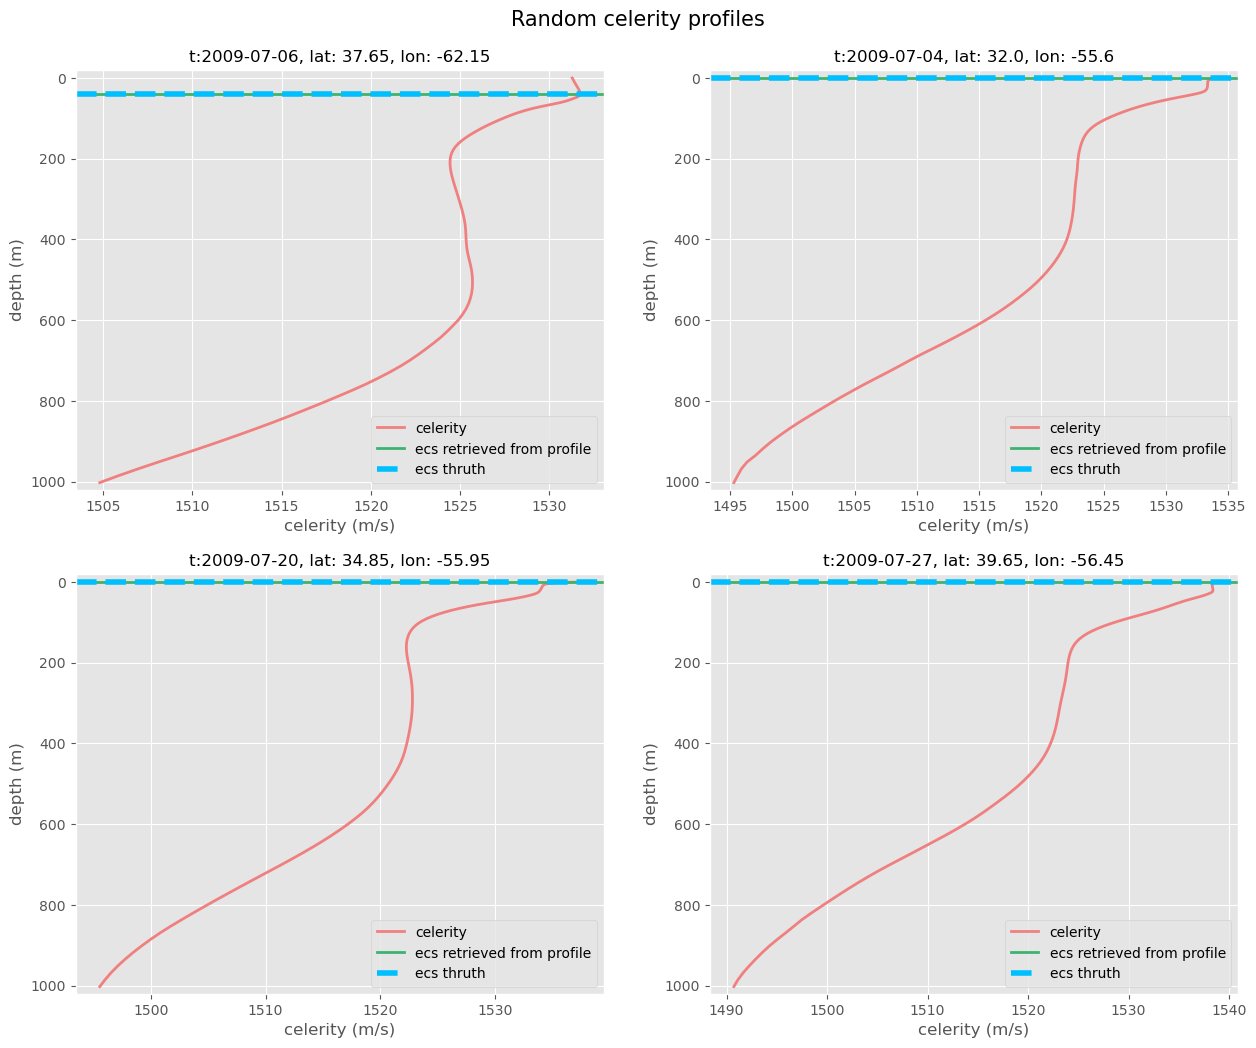

In [13]:
plot_4_profiles(ssf_da,ecs_da,profile_idx_dict, profiles="random_1000")

# ECS binary classification

In [28]:

z = coords['z'].data
for i in range (4):
    
    idx_tuple = profile_idx_dict["random_1000"][i]
    c = ssf_da.isel(time = idx_tuple[0], lat = idx_tuple[1], lon = idx_tuple[2]).data
    
    print(get_ecs_binary_classification_along_profiles(z,c))
    print(get_ecs(z,c))
    print(get_ecs_existence(z,c))


    
    

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
40.53804942088177
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [29]:
c_array = ssf_da.data.reshape(-1,107)

In [16]:
c_array

array([[1532.43496277, 1532.45007985, 1532.45451548, ..., 1496.2483326 ,
        1495.5287077 , 1494.88524982],
       [1532.38885005, 1532.40390641, 1532.40687515, ..., 1496.42020206,
        1495.70433146, 1495.06374874],
       [1532.34440192, 1532.35938607, 1532.36131051, ..., 1496.65925992,
        1495.97002116, 1495.35229435],
       ...,
       [1495.5939157 , 1495.3559575 , 1495.34723816, ..., 1483.43779568,
        1483.6377166 , 1483.8448599 ],
       [1497.15817594, 1496.97697983, 1496.91757044, ..., 1483.49450255,
        1483.693036  , 1483.8981669 ],
       [1496.78400935, 1496.54823012, 1496.4508412 , ..., 1483.47425484,
        1483.67310244, 1483.8786174 ]])

In [17]:
ssf_da.shape

(365, 240, 240, 107)

In [18]:
ecs_classif_array = np.zeros(c_array.shape)

In [19]:
for i in tqdm(range(c_array.shape[0]), unit = "profiles", desc = "Binary classification of ECS"):
    c = c_array[i,:]
    ecs_classif_array[i,:] = get_ecs_binary_classification_along_profiles(z,c)
    

Binary classification of ECS:   0%|          | 0/21024000 [00:00<?, ?profiles/s]

Binary classification of ECS:  59%|█████▉    | 12369173/21024000 [01:40<01:05, 132042.63profiles/s]

In [ ]:
ecs_classif_array = ecs_classif_array.reshape()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
ecs_classif_array = ecs_classif_array.reshape(ssf_da.shape)

In [ ]:
for i in range (4):
    
    idx_tuple = profile_idx_dict["random_1000"][i]
    c = ssf_da.isel(time = idx_tuple[0], lat = idx_tuple[1], lon = idx_tuple[2]).data
    
    print(ecs_classif_array[idx_tuple[0],idx_tuple[1],idx_tuple[2],:])
    print(get_ecs(z,c))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
40.53804942088177
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [ ]:
saving_coords = xr.open_dataarray(ss_path).coords

In [ ]:
xr.open_dataarray(ss_path)

<xarray.DataArray 'celerity' (time: 365, z: 107, lat: 240, lon: 240)>
[2249568000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [ ]:
saving_coords

Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [ ]:
ecs_classif_array.transpose(0,3,2,1).shape

(365, 107, 240, 240)

In [ ]:
ecs_classif_array.astype(np.uint8)

array([[[[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

In [ ]:
ecs_classif_da = xr.DataArray(data = ecs_classif_array.astype(np.uint8).transpose(0,3,2,1), coords = saving_coords)
ecs_classif_da

<xarray.DataArray (time: 365, z: 107, lat: 240, lon: 240)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
...
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [155]:
#ecs_classif_da.to_netcdf(path="/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_binary_classification_at_0_regrid_0_1000m.nc", mode = "w")

In [31]:
ecs_classif_array = np.zeros(c_array.shape[0])

for i in tqdm(range(c_array.shape[0]), unit = "profiles", desc = "Binary classification of ECS"):
    c = c_array[i,:]
    ecs_classif_array[i] = get_ecs_existence(z,c)

Binary classification of ECS: 100%|██████████| 21024000/21024000 [02:10<00:00, 160864.03profiles/s]


In [38]:
ssf_da.shape[:-1]

(365, 240, 240)

In [39]:
ecs_classif_array = ecs_classif_array.reshape(ssf_da.shape[:-1])

In [40]:
ecs_classif_array = ecs_classif_array.astype(np.uint8)

In [42]:
saving_coords = xr.open_dataarray(ecs_path).coords
saving_coords

In [44]:
ecs_classif_da = xr.DataArray(data = ecs_classif_array, coords = saving_coords)
ecs_classif_da

<xarray.DataArray (time: 365, lat: 240, lon: 240)>
array([[[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [45]:
ecs_classif_da.to_netcdf(path="/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_existence_at_0_regrid_0_1000m.nc", mode = "w")

# ECS explicit


In [19]:
ecs_classif_ckpt_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor_V2/ECS_explicit_pred_3D/2024-06-19_15-42/checkpoints/val_loss=0.14-epoch=00.ckpt"

In [20]:
cfg_ecs_classif = get_cfg_from_from_ckpt_path(ecs_classif_ckpt_path, pprint = True)
lit_mod = hydra.utils.call(cfg_ecs_classif.model)

```yaml

datamodule:
  _target_: src.data.BaseDatamodule
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_da, ecs_da_path: '${paths.variables}',
    ssf_da_path: '${paths.sound}'}
  x_max: ${normalization.x_max}
  x_min: ${normalization.x_min}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.acoustic_predictor_V2.AcousticPredictor
  ecs_classif_ckpt_path: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/ap_classif/UNet_2D/2024-05-30_16-59/checkpoints/val_loss=0.36-epoch=18.ckpt"
  loss_hparams: ${model_config.loss_hparams.${model.loss_name}}
  loss_name: DiceBCELoss
  loss_weight: {classif_weight: 1, pred_weight: 1}
  mask_type: None
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.01}
model_architecture: ECS_explicit_pred
model_config:
  BCELoss_weight: 0.5
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  loss_hparams:
    BCELoss: {reduction: mean, weight: '${model_config.BCELoss_weight}'}
    DiceBCELoss: {epsilon: 1, reduction: mean, weight: '${model_config.BCELoss_weight}'}
    DiceLoss: {epsilon: 1}
  model_hparams:
    CNN_2D:
      avg_pool: false
      batch_norm: true
      channels_start: 20
      dtype_str: ${dtype}
      final_act_func: Sigmoid
      in_ch: 107
      num_classes: 1
      num_layers: 4
      spatial_dim: [240, 240]
    CNN_3D:
      avg_pool: false
      batch_norm: true
      channels_start: 20
      dtype_str: ${dtype}
      final_act_func: Sigmoid
      in_ch: 3
      num_classes: 1
      num_layers: 4
      spatial_dim: [240, 240]
    CNN_with_classif_3D:
      avg_pool: false
      batch_norm: true
      channels_start: 20
      dtype_str: ${dtype}
      in_ch: 3
      loss_weight: {ecs_weight: 10, no_ecs_weight: 1}
      num_classes_classif: 2
      num_classes_pred: 1
      num_layers: 4
      spatial_dim: [240, 240]
    Dense_CNN_2D: {acoustic_variables: 1, dtype_str: '${dtype}', input_depth: 107,
      num_layers: 4}
    ECS_explicit_pred_3D:
      depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
normalization: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc, variables: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc}
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: 5, verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, name: '${model.model_name}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/accoustic_predictor_V2/",
    version: '${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 1
  min_epochs: 0


```

In [21]:
lit_mod.load_state_dict(torch.load(ecs_classif_ckpt_path)["state_dict"])

<All keys matched successfully>

In [22]:
lit_mod = lit_mod.to('cuda') # Move model to gpu for faster inference
lit_mod = lit_mod.eval() # Model in eval mode
for param in lit_mod.parameters():
    param.requires_grad = False  # Ensure no gradients are calculated for this model


In [23]:
#input_batch = lit_mod.transfer_batch_to_device(batch, lit_mod.device, 0) # Move batch to same device

In [31]:
lit_mod.model

ECS_explicit_pred_3D()

In [32]:
writer = SummaryWriter(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/graph/{cfg_ecs_classif.model.model_name}")
writer.add_graph(lit_mod.model, X)

After unsqueeze: False None
After first conv3d (derivative): False None
After torch.sign (sign): False None


/homes/o23gauvr/Documents/thèse/code/FASCINATION/src/acoustic_predictor_V2.py:197: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)


After third conv3d (sign_diff): False None
After torch.tanh (sign_change): False None
After element-wise multiplication (sign_change): False None
After torch.cumsum (mask): False None
After ecs_pred calculation: False None
After ecs_classif calculation: False None
After unsqueeze: False None
After first conv3d (derivative): False None
After torch.sign (sign): False None
After third conv3d (sign_diff): False None
After torch.tanh (sign_change): False None


/homes/o23gauvr/Documents/thèse/code/FASCINATION/src/acoustic_predictor_V2.py:234: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  depth_array_tens = torch.tensor(np.expand_dims(self.depth_array[:mask.shape[2]], axis = (0,2,3))).to(ssp.device).type(sign_change.dtype)


After element-wise multiplication (sign_change): False None
After torch.cumsum (mask): False None
After ecs_pred calculation: False None
After ecs_classif calculation: False None
After unsqueeze: False None
After first conv3d (derivative): False None
After torch.sign (sign): False None
After third conv3d (sign_diff): False None
After torch.tanh (sign_change): False None
After element-wise multiplication (sign_change): False None
After torch.cumsum (mask): False None
After ecs_pred calculation: False None
After ecs_classif calculation: False None


In [4]:
def explicit_ecs(ssp, depth_array, tau = 100):
    ssp = ssp.unsqueeze(1).nan_to_num()          
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    
        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = torch.tensor(np.expand_dims(depth_array[:mask.shape[2]], axis = (0,1,2))).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=-1).values 
    return ecs_pred

In [4]:
ssp_init = torch.tensor(ssf_da.data).float()

In [5]:
depth_ar = ssf_da.z.data

In [6]:
del ssf_da

In [7]:
ecs_pred = explicit_ecs(ssp, depth_ar)

In [11]:
ecs_pred_da = xr.DataArray(data=ecs_pred.detach().numpy(), coords=ecs_da.coords)

In [31]:
ecs_pred_da.to_netcdf("/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc")